In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
eigs = torch.tensor((0, 1, 1, 2, 3, 4, 4, 4, 4))

J = torch.diag(eigs) + torch.diag(torch.tensor([0, 1, 0, 0, 0, 1, 1, 1]), diagonal=1)
J = J.float()
X = torch.rand(J.shape)

A = X @ J @ X.inverse()

In [3]:
A = torch.tensor([
    [10, 1, 0],
    [0, -10, 1],
    [0, 0, 10]
], dtype=torch.float64)

In [4]:
i = torch.complex(torch.tensor(0., dtype=torch.float64), torch.tensor(1., dtype=torch.float64))

In [5]:
torch.linalg.matrix_exp(i*A).real

tensor([[-0.8391,  0.0000,  0.0272],
        [ 0.0000, -0.8391,  0.0000],
        [ 0.0000,  0.0000, -0.8391]], dtype=torch.float64)

---

## Special formula for Jordan block form

In [6]:
from functools import reduce
from torch import func
from math import factorial

def jordan_form_func(function):
    def split_jordan_blocks(matrix):
        """
        Split a Jordan normal form matrix into its individual Jordan blocks.

        Parameters:
            matrix (torch.Tensor): The input square Jordan normal form matrix.

        Returns:
            list: A list of tensors, each representing an individual Jordan block.
        """
        n = matrix.size(0)
        blocks = []
        start_idx = 0

        for i in range(n - 1):
            if matrix[i, i + 1] != 1:  # End of a block
                # Extract the block
                blocks.append(matrix[start_idx:i + 1, start_idx:i + 1])
                start_idx = i + 1

        # Add the last block
        if start_idx < n:
            blocks.append(matrix[start_idx:n, start_idx:n])

        return blocks

    def grad(f, n=0):
        return func.vmap(reduce(lambda f, _: torch.func.grad(f), range(n), f))

    def wrapper(input):

        input = input.reshape((1, 1)) if not input.dim() else input
        assert input.size(0) == input.size(1), "Input must be a square matrix"

        eigs = input.diagonal()

        output = function(eigs).diag()

        block_start_idx = 0
        for block in split_jordan_blocks(input):
            block_size = len(block)
            eig = block.diagonal()
            block_slice = slice(block_start_idx, block_start_idx+block_size)

            for i in range(1, block_size):
                output[block_slice, block_slice] += grad(function, i)(eig[:-i]).diag(diagonal=i) / factorial(i)

            block_start_idx += block_size

        return output

    return wrapper

In [7]:
@jordan_form_func
def f(x):
    return torch.sin(x)*torch.cos(x)


f(J)

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.0000,  0.4546, -0.4161,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.0000,  0.0000,  0.4546,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.3784,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.1397,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.4947, -0.1455, -0.9894,
          0.0970],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.4947, -0.1455,
         -0.9894],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.4947,
         -0.1455],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.4947]])

## Taylor expansion for general matrix

In [8]:
import functools


def taylor_extension(n_terms = 50, loc = 0):
    def compute_taylor(input, function):

        input = input.reshape((1, 1)) if not input.dim() else input
        assert input.size(0) == input.size(1), "Input must be a square matrix"

        x_loc = loc * torch.ones((1, 1), requires_grad=True).type(torch.float64)

        factorial = torch.tensor([1.]).type_as(input)
        grad_fn = function(x_loc)
        matrix_power = torch.eye(input.size(0)).type_as(input)

        output = grad_fn / factorial * matrix_power

        for term in range(1, n_terms):

            grad_fn = torch.autograd.grad(grad_fn.sum().real, x_loc, create_graph=True)[0]
            factorial *= term
            matrix_power @= input

            output += grad_fn / factorial * matrix_power

        return output

    def decorator(function):
        @functools.wraps(function)
        def wrapper(input):
            return compute_taylor(input=input, function=function)
        return wrapper
    
    # Handle the case where the decorator is used without parentheses
    if callable(n_terms):
        # Swapping ensures `n_terms` gets its default value
        function, n_terms = n_terms, 50
        return decorator(function)

    return decorator

In [9]:
A = torch.tensor([
    [10, 1, 0],
    [0, -10, 1],
    [0, 0, 10]
], dtype=torch.float64)

x = torch.tensor(1., dtype=torch.float64)

In [10]:
taylor_extension(30)(torch.exp)(i*A).imag

tensor([[-0.5429, -0.0543, -0.0391],
        [ 0.0000,  0.5429, -0.0543],
        [ 0.0000,  0.0000, -0.5429]], dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [11]:
(torch.linalg.matrix_exp(A) - taylor_extension(120)(torch.exp)(A)).norm()

tensor(1.5525e-11, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)

In [12]:
@taylor_extension(n_terms=10)
def g(x):
    return torch.sin(x)

g(x) - torch.sin(x)

tensor([[2.4892e-08]], dtype=torch.float64, grad_fn=<SubBackward0>)

In [13]:
@taylor_extension(5)
def h(x):
    return torch.sin(x)**2 + torch.cos(x)**2

h(x)

tensor([[1.]], dtype=torch.float64, grad_fn=<AddBackward0>)

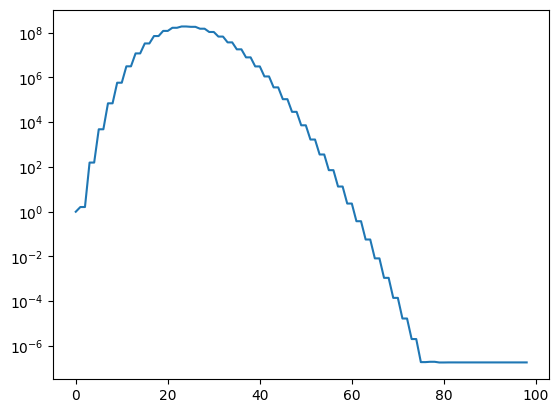

In [36]:
from scipy.linalg import sinm
import numpy as np

B = torch.rand((50, 50), dtype=torch.float64)

loss = [np.linalg.norm((sinm(B) - taylor_extension(n)(torch.sin)(B).data.numpy())) / np.linalg.norm((sinm(B))) for n in range(1, 100)]
plt.plot(loss)
plt.yscale('log')

# loss = [np.linalg.norm((sinm(B) - taylor_extension(n)(torch.exp)(i*B).imag.data.numpy())) / np.linalg.norm((sinm(B))) for n in range(1, 100)]
# plt.plot(loss)

In [12]:
B = torch.rand((50, 50), dtype=torch.float64)

(torch.linalg.matrix_exp(B) - taylor_extension(200)(torch.exp)(B)).norm()

tensor(8.5984e-05, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)